<a href="https://colab.research.google.com/github/jkcg-learning/PoseEstimation/blob/main/Mediapipe_Keypoint_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Mediapipe Pose](https://google.github.io/mediapipe/solutions/pose.html)

#Models

###Person/pose Detection Model (BlazePose Detector)

The detector is inspired by our own lightweight BlazeFace model, used in MediaPipe Face Detection, as a proxy for a person detector. It explicitly predicts two additional virtual keypoints that firmly describe the human body center, rotation and scale as a circle. Inspired by Leonardo’s Vitruvian man, we predict the midpoint of a person’s hips, the radius of a circle circumscribing the whole person, and the incline angle of the line connecting the shoulder and hip midpoints.

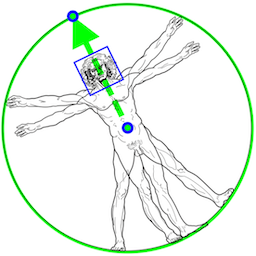

#Pose Landmark Model (BlazePose GHUM 3D)

The landmark model in MediaPipe Pose predicts the location of 33 pose landmarks (see figure below).

GHUM : Generative 3D Human Shape and Articulated Pose Models

[GHUM](https://github.com/google-research/google-research/tree/master/ghum)

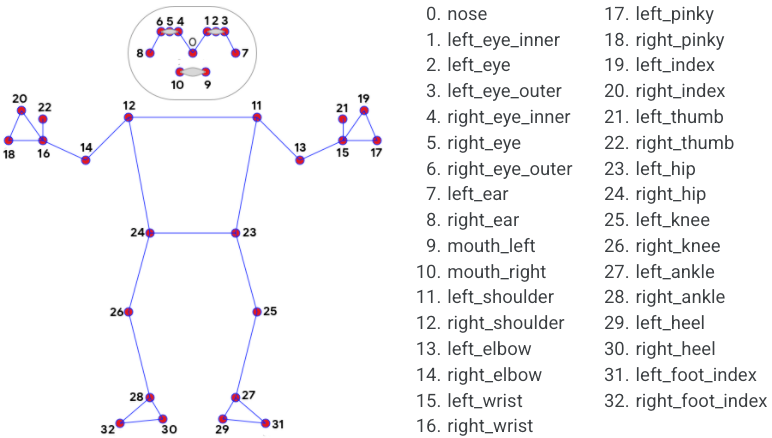

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import time

In [ ]:
import matplotlib.pyplot as plt
import json
from google.colab.patches import cv2_imshow

##Output

###POSE_LANDMARKS
A list of pose landmarks. Each landmark consists of the following:

-x and y: Landmark coordinates normalized to [0.0, 1.0] by the image width and height respectively.

-z: Represents the landmark depth with the depth at the midpoint of hips being the origin, and the smaller the value the closer the landmark is to the camera. The magnitude of z uses roughly the same scale as x.

-visibility: A value in [0.0, 1.0] indicating the likelihood of the landmark being visible (present and not occluded) in the image.

In [ ]:
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mp_drawing = mp.solutions.drawing_utils
circle_radius = int(.007*100)
point_spec = mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=-1, circle_radius= circle_radius)
line_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=3)



cap = cv2.VideoCapture('/content/workout_1.mp4')
video_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

#print(video_size)
fourcc = cv2.VideoWriter_fourcc(*'mpeg')
fps_out = 20
video_output = cv2.VideoWriter('/content/workout_demo_output.mp4', fourcc, fps_out, video_size)

pTime = 0

pose_results = {}
keypoints={}
keypoint_list = []
frame_id = 0

while (cap.isOpened()):

    success, img = cap.read()

    if (success == False):
      break

    else:  
      #img = cv2.resize(img, (480, 320))
      imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
      results = pose.process(imgRGB)

      if results.pose_landmarks:

          mp_drawing.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS,
                                    landmark_drawing_spec=point_spec,
                                    connection_drawing_spec=line_spec)

          for id, lm in enumerate(results.pose_landmarks.landmark):

              keypoints={}
              h, w,c = img.shape
              cx, cy = int(lm.x*w), int(lm.y*h)
              keypoints['keypoint_id'] = id
              keypoints['keypoint_x'] = lm.x  
              keypoints['keypoint_y'] = lm.y
              keypoints['keypoint_z'] = lm.z
              keypoints['keypoint_visibility_score'] = lm.visibility
        
              keypoint_list.append(keypoints)

              cv2.circle(img, (cx, cy), 5, (255,0,0), cv2.FILLED)


      cTime = time.time()
      fps = 1/(cTime-pTime)
      pTime = cTime
      #print(fps)

      cv2.putText(img, "fps: "+str(int(fps)), (100,100), cv2.FONT_HERSHEY_SIMPLEX,3,(0,0,255), 3)
      #cv2_imshow(img)
      #cv2.waitKey(1)
      video_output.write(img)
      pose_results['frame_id'] = frame_id    
      pose_results['keypoints'] = keypoint_list
          
      with open('keypoints_logs.json', 'a+', encoding='utf-8') as f:
          json.dump(pose_results, f, ensure_ascii=False, indent=4) 
      frame_id += 1
      keypoint_list = []

  
f.close() 
cap.release()
video_output.release()
cv2.destroyAllWindows()